
La base de données de reconnaissance des gestes de la main est une collection d'images dans le proche infrarouge de 16 gestes de la main distincts. Dans ce cahier, nous utilisons l'apprentissage en profondeur de bout en bout pour créer un classificateur pour ces images.

Nous allons d'abord charger quelques packages nécessaires à la lecture et au traçage des images.



In [63]:
import numpy as np # We'll be storing our data as numpy arrays
import pandas as pd
import os # For handling directories
from PIL import Image # For handling the images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg # Plotting
from matplotlib.pyplot import imshow



df = pd.read_csv(r'/content/train.csv') # read 10 lines from the training data file from working directory (, nrows=100)

In [64]:
df

,id,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,...,pixel57141,pixel57142,pixel57143,pixel57144,pixel57145,pixel57146,pixel57147,pixel57148,pixel57149,pixel57150,pixel57151,pixel57152,pixel57153,pixel57154,pixel57155,pixel57156,pixel57157,pixel57158,pixel57159,pixel57160,pixel57161,pixel57162,pixel57163,pixel57164,pixel57165,pixel57166,pixel57167,pixel57168,pixel57169,pixel57170,pixel57171,pixel57172,pixel57173,pixel57174,pixel57175,pixel57176,pixel57177,pixel57178,pixel57179,pixel57180
0,0,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2994,2994,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2995,2995,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2996,2996,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2997,2997,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [65]:
df['label'].unique

<bound method Series.unique of 0       14
1        3
2       15
3        4
4       16
        ..
2994     6
2995     5
2996    16
2997    15
2998     4
Name: label, Length: 2999, dtype: int64>

Jetons un coup d'oeil à une image

In [41]:
from pylab import *

Label: 8


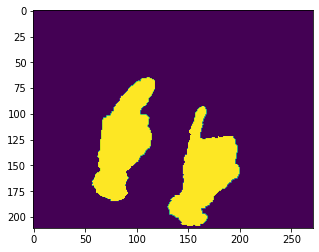

In [66]:
i = 10 # set any valid index of an image
label = df.values[i][1] # retrieve label from first colum in dataframe
im_buf = df.values[i][2:] # create flat array of only the pixels of the given image 
#axis_len = int(np.sqrt(im_buf.shape[0])) # calculate the dimensions of the square image
im_array = np.int8(np.reshape(im_buf, (211, 271))) # create a 2D array from flat array
img = Image.fromarray(im_array, 'L') # convert to a PIL.Image object ('L' is for grayscale)

print(f'Label: {label}')
imshow(np.asarray(img))
#img.show()

In [67]:
import numpy as np
from keras.layers import Dense, Activation, Convolution2D, MaxPooling2D, Dropout, Flatten
from keras.models import Sequential, save_model
from keras.utils import np_utils
import os
import cv2
from sklearn.utils import shuffle

In [68]:
X = np.array(df.values[:,2:])
Y = np.array(df.values[:,1])
np.unique(Y)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

In [69]:
X = X.reshape((X.shape[0], 211, 271, 1))

Notre ensemble d'images a une forme (Nombre d'images, 120, 320). Keras s'attendra à ce qu'un autre slot lui indique le nombre de canaux, nous remodelons donc X en conséquence. Nous redimensionnons également les valeurs dans X pour qu'elles se situent entre 0 et 1.

In [71]:
X = X/255
X.shape

(2999, 211, 271, 1)

In [70]:
Y = np.int8(np.reshape(Y,(-1,1)))

Pour le moment notre vecteur y_data a une forme (Nombre d'images, 1). Afin de le convertir au format one-hot, nous utilisons la fonction keras to_categorical :

In [72]:
import keras
from tensorflow.keras.utils import to_categorical
Y = to_categorical(Y)

In [73]:
Y = Y[:,1:]

In [74]:
Y.shape

(2999, 16)

In [75]:
np.unique(Y)

array([0., 1.], dtype=float32)

Nous avons besoin d'un ensemble de cross-validation et d'un ensemble de test, et nous utiliserons le package sklearn pour les construire. Afin d'obtenir une division 80-10-10, nous appelons train_test_split deux fois, d'abord pour diviser 80-20, puis pour diviser le plus petit morceau 50-50. Notez que nous le faisons après l'étape de rescaling ci-dessus, pour nous assurer que nos ensembles d'apprentissage et de test proviennent de la même distribution.

In [76]:
from sklearn.model_selection import train_test_split
x_train,x_further,y_train,y_further = train_test_split(X,Y,test_size = 0.2)
x_validate,x_test,y_validate,y_test = train_test_split(x_further,y_further,test_size = 0.5)

In [77]:
from keras import layers
from keras import models


Étant donné que nos images sont grandes (nous avons choisi de ne pas recadrer) et que le problème de classification semble assez facile, nous allons sous-échantillonner de manière assez agressive, en commençant par un filtre 5 x 5 avec un stride de 2. Notez que nous devons spécifier le input shape correcte à cette couche initiale, et keras le découvrira à partir de là. Nous ne nous soucierons pas du padding car il est clair que toutes les fonctionnalités utiles sont bien à l'intérieur de l'image. Nous continuerons avec une séquence de couches convolutives suivies d'un max-padding jusqu'à ce que nous arrivions à une image suffisamment petite pour pouvoir ajouter une couche entièrement connectée. Puisqu'il faut classer entre 16 possibilités, on termine avec une couche softmax à 16 neurones

In [78]:
model=models.Sequential()
model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), activation='relu',padding='same', input_shape=(211, 271,1))) #211, 271, 1
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu')) 
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(226, activation='relu'))
model.add(layers.Dense(120, activation='relu'))
model.add(layers.Dense(16, activation='softmax'))

In [79]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [80]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 106, 136, 32)      832       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 53, 68, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 51, 66, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 25, 33, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 23, 31, 64)        36928     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 11, 15, 64)      

In [81]:
model.fit(x_train, y_train, epochs=10, batch_size=256, verbose=1, validation_data=(x_validate, y_validate))

Epoch 1/10
10/10 [==============================] - 61s 6s/step - loss: 2.2220 - accuracy: 0.3218 - val_loss: 0.9476 - val_accuracy: 0.8333
Epoch 2/10
10/10 [==============================] - 59s 6s/step - loss: 0.5684 - accuracy: 0.8341 - val_loss: 0.1057 - val_accuracy: 0.9767
Epoch 3/10
10/10 [==============================] - 59s 6s/step - loss: 0.2658 - accuracy: 0.9516 - val_loss: 0.0601 - val_accuracy: 0.9933
Epoch 4/10
10/10 [==============================] - 59s 6s/step - loss: 0.0282 - accuracy: 0.9950 - val_loss: 0.0064 - val_accuracy: 1.0000
Epoch 5/10
10/10 [==============================] - 59s 6s/step - loss: 0.1648 - accuracy: 0.9758 - val_loss: 0.0697 - val_accuracy: 0.9867
Epoch 6/10
10/10 [==============================] - 58s 6s/step - loss: 0.0156 - accuracy: 0.9983 - val_loss: 0.0024 - val_accuracy: 1.0000
Epoch 7/10
10/10 [==============================] - 58s 6s/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 8/10
10/10 [==

À ce stade, nous représenterions généralement graphiquement la précision de notre modèle sur l'ensemble de validation et choisirions un nombre approprié d'époques pour s'entraîner afin d'éviter le surapprentissage. Nous pourrions également envisager d'introduire l'abandon et la régularisation. Cependant, nous pouvons voir que nous obtenons une précision parfaite sur l'ensemble de validation après seulement une ou deux époques, nous avons donc à peu près terminé. Confirmons rapidement que cela se poursuit jusqu'à l'ensemble de test :

In [82]:
[loss, acc] = model.evaluate(x_test,y_test,verbose=1)
print("Accuracy:" + str(acc))

10/10 [==============================] - 2s 203ms/step - loss: 0.0113 - accuracy: 0.9967
Accuracy:0.996666669845581
